In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pystan
import math
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [62]:
df=pd.read_csv("../input/q_data_x.csv")

In [63]:
df["TVwatch_day"]=df["TVwatch_day"]/10000

In [64]:
#スケール＋切り上げ
df["gamesecond"]=[math.ceil(i/10000) for i in df["gamesecond"]]

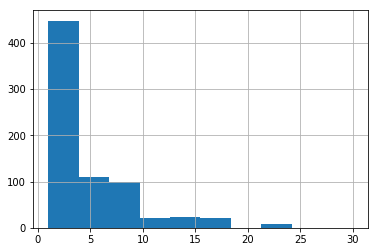

In [65]:
df["gamesecond"].hist(range=(1,30))

In [66]:
X=df[['cm_dummy','T','F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',"child_dummy"]]
#X=df[['cm_dummy','T','F1', 'F2', 'F3', 'M1', 'M2', 'M3']]

In [67]:
model="""
data {
  int N;
  int D;
  int<lower=0> Y[N];
  matrix[N,D] X;
}

parameters {
  vector[D] b1;
  real<lower=0> beta;
}

transformed parameters {
  vector[N] alpha_x;
  vector[N] alpha;
  
  alpha_x = X*b1;
  for (n in 1:N){
    alpha[n] = exp(alpha_x[n]);
    }
}

model {
  for (n in 1:N)
    Y[n] ~ neg_binomial_2(alpha[n], beta);
}
"""

'別ver(たぶん同じ動作)\nif (Y[n] == 0) {\n      increment_log_prob(log_sum_exp(\n        bernoulli_log(0 , q[n]),\n        bernoulli_log(1 , q[n]) + neg_binomial_2_log(0 , alpha,beta)\n        ));\n    } else {\n      increment_log_prob(bernoulli_log(1 , q[n]) + neg_binomial_2_log(Y[n] , alpha,beta));\n'

In [68]:
data={'N': X.shape[0], 'D':X.shape[1] ,'Y':df["gamesecond"].values, 'X':np.array(X)}

In [69]:
%time fit = pystan.stan(model_code=model, data=data, iter=1000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_efc1185b6d99287b08f521e9025bbeef NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 2.59 s, sys: 15.6 s, total: 18.2 s
Wall time: 3min 6s


In [70]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_efc1185b6d99287b08f521e9025bbeef.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1[1]       5.0e-3  3.9e-3   0.14  -0.27  -0.08 2.5e-3    0.1   0.27   1219    1.0
b1[2]        -0.27    0.01   0.52  -1.16  -0.66   -0.3   0.06   0.79   1626    1.0
b1[3]        -2.01  5.1e-3   0.18  -2.37  -2.14  -2.01  -1.89  -1.64   1283    1.0
b1[4]         -1.5  6.5e-3    0.2  -1.87  -1.65   -1.5  -1.37  -1.11    963    1.0
b1[5]        -1.91  8.7e-3   0.29  -2.48   -2.1  -1.91  -1.71  -1.33   1139   1.01
b1[6]        -0.38  3.9e-3   0.16  -0.69  -0.49  -0.38  -0.28  -0.05   1647    1.0
b1[7]        -1.01  4.7e-3   0.15   -1.3  -1.11  -1.01   -0.9  -0.74    970    1.0
b1[8]        -2.21  5.2e-3   0.17  -2.53  -2.33  -2.21  -2.09  -1.86   1095    1.0
b1[9]        -0.04  2.5e-3

In [71]:
# サンプル列を抽出
la  = fit.extract(permuted=True)

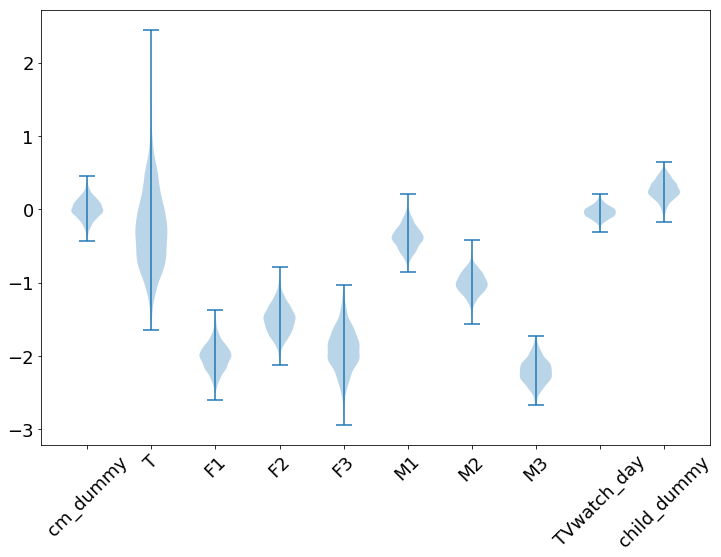

In [72]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["b1"][:,i] for i in range(10)])
plt.xticks(list(range(1,len(X.columns)+1)), X.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

In [74]:
#numpyのパラメータに対応させる
mu = la["alpha"].mean()
phi = la["beta"].mean()
p = phi / (mu + phi)

In [75]:
print(mu)
print(phi)

0.3432733184828474
0.03489234662224619


In [76]:
p

0.09226735751525585

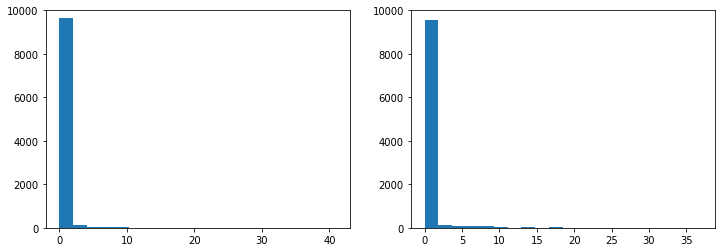

In [77]:
#推定したパラメータからサンプリングしたヒストグラム
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.ylim(0, 10000)
plt.hist(np.random.negative_binomial(phi,p, size=10000),bins=20)
#元のヒストグラム
plt.subplot(1, 2, 2)
plt.ylim(0, 10000)
plt.hist(df["gamesecond"],bins=20)
plt.show()

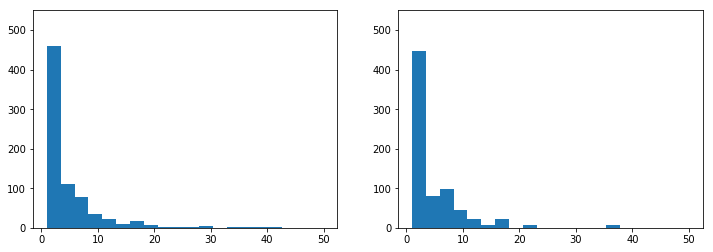

In [78]:
#推定したパラメータからサンプリングしたヒストグラム(1以上)
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.ylim(0, 550)
plt.hist(np.random.negative_binomial(phi,p, size=10000),bins=20,range=(1,50))
#元のヒストグラム
plt.subplot(1, 2, 2)
plt.ylim(0, 550)
plt.hist(df["gamesecond"],bins=20,range=(1,50))
plt.show()